In [1]:
import numpy as np
from numpy.linalg import eig
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
fcAntenna = 150e6
fs = 8000
t = np.arange(0,1,1/fs)
Lambda = 3e8 / fcAntenna
nAntenna = 10
nSample = 2048 # sample rate for calc Rx
nSource = 3
SNR = -50
degree = np.arange(-90, 90)

In [3]:
def SteeringVec(angels):
    # It is assumed that the distance of each antenna element is Lambda / 2
    steeringVec = np.zeros(nAntenna, dtype='complex_')
    k0 = 2 * np.pi / Lambda
    if np.size(angels) != 2:
        angels = [angels , 0]
    for i in range(nAntenna):
        d = i * Lambda / 2
        steeringVec[i] = np.exp(-1j * k0 * d * np.sin(angels[0]) * np.cos(angels[1]))
    return steeringVec

In [4]:
def CollectPlaneWave(angels, *args, **kwargs):
    planeWave = np.zeros((fs, nAntenna), dtype='complex_')

    steeringVec = np.zeros((nAntenna, len(args)), dtype='complex_')
    for i in range(len(args)):
        steeringVec[:, i] = SteeringVec(angels[i])

    noise = np.sqrt(1 / (10 ** (SNR / 10))) * np.random.randn(fs)
    
    amplitudeVec = np.zeros((len(args), fs))
    for i in range(len(args)):
        amplitudeVec[i, :] = args[i] + noise

    planeWave = (steeringVec @ amplitudeVec).T

    return planeWave

In [5]:
sig1 = np.cos(2 * np.pi * 300 * t)
sig2 = np.cos(2 * np.pi * 400 * t)
sig3 = np.cos(2 * np.pi * 500 * t)
signalAngels = [[60, 0], [5, 0], [-90, 0]]
sig = CollectPlaneWave(signalAngels, sig1, sig2, sig3)

In [6]:
np.shape(sig)

(8000, 10)

In [7]:
def MUSIC(data, nSample, nSource, fs, angels):
    # nSample = num of snapshots
    # steeringVec = recived signal
    # nSource = num of source signals
    # fs = sampling freq

    # calculate correlate matrix
    R = (data[0:nSample, :].T @ data[0:nSample, :].conj()) / nSample

    # calculate eigenvalues and eigenvectors of the correlate matrix
    eigenvalues, eigenvectors = eig(R)
    sorted_index = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalue = eigenvalues[sorted_index]
    sorted_eigenvectors = eigenvectors[:, sorted_index]

    # noise subspace
    Qn = sorted_eigenvectors[:, nSource:]

    steeringVec = SteeringVec(angels)

    steeringVecTranspose = np.matrix(steeringVec).getH()

    Pmusic = steeringVecTranspose.T @ Qn @ np.matrix(Qn).getH() @ steeringVec.T
    out_vec = 1 / Pmusic.real

    return out_vec

C:\Users\asakh\AppData\Local\Temp\ipykernel_6244\1164476262.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result[i] = MUSIC(sig, nSample, nSource, fs, degree[i])


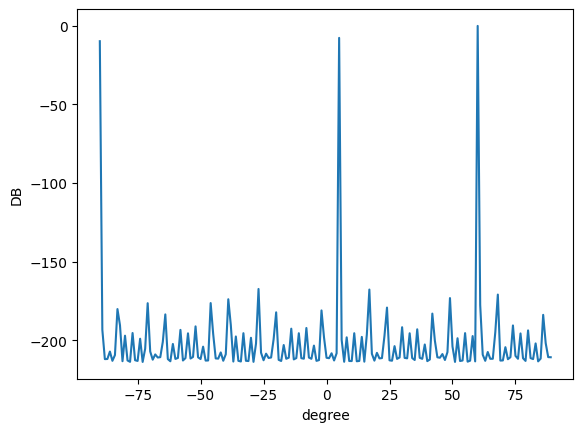

In [8]:
result = np.zeros(len(degree))
for i in range(0, 180):
    result[i] = MUSIC(sig, nSample, nSource, fs, degree[i])
result = 10 * np.log10(result / np.max(result))
plt.plot(degree, result)
plt.xlabel('degree')
plt.ylabel('DB')
plt.show()